# Backprop ninja from scratch

Implement makemore part 4 (comment `loss.backward()` and write backprop stepwise) from an empty  notebook

## Create dataset

In [1]:
with open('../names.txt', 'r') as file:
    names = file.read().splitlines()

len(names)

32033

In [2]:
chars = sorted(list(set("".join(name for name in names))))
len(chars)

26

In [3]:
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, ch in enumerate(chars):
    stoi[ch] = i + 1
    itos[i + 1] = ch

len(stoi), len(itos)

(27, 27)

In [4]:
from sklearn.model_selection import train_test_split

# Set the random seed for reproducibility
random_seed = 42

# Split the dataset into train and temp sets (80% train, 20% temp)
train_names, temp_names = train_test_split(names, test_size=0.2, random_state=random_seed)

# Split the temp set into validation and test sets (50% val, 50% test of the 20% temp set)
val_names, test_names = train_test_split(temp_names, test_size=0.5, random_state=random_seed)

len(train_names), len(val_names), len(test_names)

(25626, 3203, 3204)

In [5]:
import torch

def create_dataset(names, block_size):
    X, y = [], []

    for name in names:
        name = ['.'] * block_size + list(name) + ['.']
        for i, ch in enumerate(name[block_size:]):
            input_seq, output_char = name[i:i+block_size], ch
            X.append([stoi[c] for c in input_seq])
            y.append(stoi[output_char])

    X = torch.LongTensor(X)
    y = torch.LongTensor(y)

    return X, y

In [6]:
block_size = 3
X_train, y_train = create_dataset(train_names, block_size)
X_val, y_val = create_dataset(val_names, block_size)
X_test, y_test = create_dataset(test_names, block_size)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([182497, 3]),
 torch.Size([182497]),
 torch.Size([22882, 3]),
 torch.Size([22882]),
 torch.Size([22767, 3]),
 torch.Size([22767]))

## Backprop ninja exercise 1: Atomic portions of the backprop

We split every small portion of the model and compute gradients of the same

## Learnings:
- Always use `clone` when just copying a tensor.
- Be careful about backproping in maximum
- Avoid dividing instead use ** or simple multiply by reciprocal

In [7]:
g = torch.Generator().manual_seed(2147483647)

emb_dim = 10
hidden_dim = 400
vocab_size = len(stoi)
block_size = 3

# emb matrix
C = torch.randn((vocab_size, emb_dim), dtype=torch.float32, generator=g)

# 1st linear layer
W1 = torch.randn((emb_dim * block_size, hidden_dim), dtype=torch.float32, generator=g) * 1/((emb_dim * block_size)**0.50)
b1 = torch.randn(hidden_dim, dtype=torch.float32, generator=g) * 0.10 # not really needed due to BN so expect the grads to be very small

# BatchNorm layer
bngain = torch.randn((1, hidden_dim), dtype=torch.float32, generator=g)
bnbias = torch.randn((1, hidden_dim), dtype=torch.float32, generator=g)

# 2nd linear layer
W2 = torch.randn((hidden_dim, vocab_size), dtype=torch.float32, generator=g) * 1/((hidden_dim)**0.50) * 0.10
b2 = torch.randn(vocab_size, dtype=torch.float32, generator=g) * 0.10

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

24297


In [8]:
# forward pass step by step

batch_size = 128

idx = torch.randint(0, len(X_train), (batch_size,), generator=g)
Xb, yb = X_train[idx], y_train[idx]

# embedding indexing
emb = C[Xb]

# 1st linear layer
embcat = emb.view(batch_size, -1)
h1 = embcat @ W1 + b1

# Batchnorm layer
bnmean = (1/batch_size) * torch.sum(h1, dim=0, keepdim=True)
bndiff = h1 - bnmean
bndiff2 = bndiff**2
bnvar = (1/(batch_size - 1)) * torch.sum(bndiff2, dim=0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hbn = bnraw * bngain + bnbias

# Tanh layer
hact = torch.tanh(hbn)

# 2nd linear layer
logits = hact @ W2 + b2

# Loss computation
logits_max = logits.max(dim=1, keepdim=True).values
norm_logits = logits - logits_max
counts = norm_logits.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
probs_idx = probs[range(batch_size), yb]
log_probs = probs_idx.log()
loss = -log_probs.mean()

for p in parameters:
    p.grad = None

for t in [emb, embcat, h1, bnmean, bndiff, bndiff2, bnvar, bnvar_inv, bnraw, hbn, hact,\
          logits, logits_max, norm_logits, counts, counts_sum, counts_sum_inv, probs, probs_idx, log_probs]:
    t.retain_grad()

loss.backward()
loss.item()

3.2864649295806885

In [85]:
def cmp(tensor_name, t, dt):
    exact = str(torch.all(t.grad == dt).item())
    approx = str(torch.torch.allclose(t.grad, dt))
    max_diff = (t.grad - dt).abs().max().item()
    print(f"{tensor_name:35s} | exact: {exact:5s} | approximate: {approx:5s} | max difference:{max_diff}")

In [19]:
# line 39 loss = log_probs.mean() log_probs shape : [B, 1]
dlog_probs = -1/batch_size * torch.ones_like(log_probs)

# line 38 log_probs = probs_idx.log() probs_idx shape : [B, 1]
dprobs_idx = (1 / probs_idx) * dlog_probs

# line 37 probs_idx = probs[range(batch_size), yb] probs shape : [B, V]
dprobs = torch.zeros_like(probs)
dprobs[range(batch_size), yb] = dprobs_idx

# line 36 probs = counts * counts_sum_inv , counts shape : [B ,V], counts_sum_inv : [B, 1]
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)
dcounts = counts_sum_inv * dprobs

# line 35 counts_sum_inv = counts_sum**-1 counts_sum shape : [B, 1]
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv

# line 34 counts_sum = counts.sum(dim=1, keepdim=True)
dcounts += torch.ones_like(counts) * dcounts_sum

# line 33 counts = norm_logits.exp() norm_logits shape : [B, V]
dnorm_logits = norm_logits.exp() * dcounts

# line 32 norm_logits = logits - logits_max , logits shape : [B, V], logits_max : [B, 1]
dlogits = dnorm_logits.clone()
dlogits_max = (-dnorm_logits).sum(dim=1, keepdim=True)

# line 31 logits_max = logits.max(dim=1, keepdim=True).values
## CAREFUL for max backprop
max_indices = logits.max(dim=1, keepdim=True).indices.view(-1)
dlogits[range(batch_size), max_indices] += dlogits_max[range(batch_size), 0]

# line 28 logits = hact @ W2 + b2, hact shape: [B, H], W2 shape: [H, V], b2 shape: [V]
dhact = dlogits @ W2.T
dW2 = hact.T @ dlogits
db2 = dlogits.sum(dim=0, keepdim=True).view(-1)

# line 25 hact = torch.tanh(hbn) hbn shape: [B, H]
dhbn = (1 - hact**2) * dhact

# line 22 hbn = bnraw * bngain + bnbias bnraw shape: [B, H], bngain shape: [1, H], bnbias shape: [1, H]
dbnraw = bngain * dhbn
dbngain = (bnraw * dhbn).sum(dim=0, keepdim=True)
dbnbias = (dhbn).sum(dim=0, keepdim=True)

# line 21 bnraw = bndiff * bnvar_inv bndiff shape: [B, H], bnvar_inv shape: [1, H]
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(dim=0, keepdim=True)

# line 20 bnvar_inv = (bnvar + 1e-5)**-0.5 bnvar shape: [1, H]
dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv

# line 19 bnvar = (1/(batch_size - 1)) * torch.sum(bndiff2, dim=0, keepdim=True) bndiff2 shape: [B, H]
dbndiff2 = (torch.ones_like(bndiff2) * dbnvar) * (1 / (batch_size - 1)) # prefer to multiply 1/n instead of dividing by n

# line 18 bndiff2 = bndiff**2
dbndiff += 2 * bndiff * dbndiff2

# line 17 bndiff = h1 - bnmean h1 shape: [B, H], bnmean shape: [1, H]
dh1 = dbndiff.clone()
dbnmean = (-dbndiff).sum(dim=0, keepdim=True)

# line 16 bnmean = (1/batch_size) * torch.sum(h1, dim=0, keepdim=True)
dh1 += torch.ones_like(h1) * (1/batch_size) * dbnmean

# line 13 h1 = embcat @ W1 + b1 embcat shape: [B, BS*E], W1 shape: [BS*E, H], b1 shape: [H]
dembcat = dh1 @ W1.T
dW1 = embcat.T @ dh1
db1 = dh1.sum(dim=0, keepdim=True).view(-1)

# line 12 embcat = emb.view(batch_size, -1) emb shape: [B, BS, E]
demb = dembcat.view(emb.shape)

# line 9 emb = C[Xb] C shape: [V, E], Xb shape: [B, BS]
dC = torch.zeros_like(C)
dC.index_add_(dim=0, index = Xb.view(-1), source=demb.view(-1, emb_dim));

cmp("log_probs", log_probs, dlog_probs)
cmp("probs_idx", probs_idx, dprobs_idx)
cmp("probs", probs, dprobs)
cmp("counts_sum_inv", counts_sum_inv, dcounts_sum_inv)
cmp("counts_sum", counts_sum, dcounts_sum)
cmp("counts", counts, dcounts)
cmp("norm_logits", norm_logits, dnorm_logits)
cmp("logits_max", logits_max, dlogits_max)
cmp("logits", logits, dlogits)
cmp("hact", hact, dhact)
cmp("W2", W2, dW2)
cmp("b2", b2, db2)
cmp("hbn", hbn, dhbn)
cmp("bngain", bngain, dbngain)
cmp("bnbias", bnbias, dbnbias)
cmp("bnvar_inv", bnvar_inv, dbnvar_inv)
cmp("bnvar", bnvar, dbnvar)
cmp("bndiff2", bndiff2, dbndiff2)
cmp("bndiff", bndiff, dbndiff)
cmp("bnmean", bnmean, dbnmean)
cmp("h1", h1, dh1)
cmp("embcat", embcat, dembcat)
cmp("W1", W1, dW1)
cmp("b1", b1, db1)
cmp("emb", emb, demb)
cmp("C", C, dC)

log_probs       | exact: True  | approximate: True  | max difference:0.0
probs_idx       | exact: True  | approximate: True  | max difference:0.0
probs           | exact: True  | approximate: True  | max difference:0.0
counts_sum_inv  | exact: True  | approximate: True  | max difference:0.0
counts_sum      | exact: True  | approximate: True  | max difference:0.0
counts          | exact: True  | approximate: True  | max difference:0.0
norm_logits     | exact: True  | approximate: True  | max difference:0.0
logits_max      | exact: True  | approximate: True  | max difference:0.0
logits          | exact: True  | approximate: True  | max difference:0.0
hact            | exact: True  | approximate: True  | max difference:0.0
W2              | exact: True  | approximate: True  | max difference:0.0
b2              | exact: True  | approximate: True  | max difference:0.0
hbn             | exact: True  | approximate: True  | max difference:0.0
bngain          | exact: True  | approximate: True 

## Backprop ninja exercise 2: directly backprop into the CE loss

In [20]:
loss_ce = torch.nn.functional.cross_entropy(logits, yb)
exact = str(torch.all(loss == loss_ce).item())
approx = str(torch.torch.allclose(loss, loss_ce))
max_diff = (loss - loss_ce).abs().max().item()
print(f"Loss | exact: {exact:5s} | approximate: {approx:5s} | max difference:{max_diff}")

Loss | exact: True  | approximate: True  | max difference:0.0


In [27]:
dlogits = None # logits shape [B, V]
dlogits = torch.softmax(logits, dim=1)
dlogits[range(batch_size), yb] -= 1.0
dlogits *= (1/batch_size)
cmp("logits", logits, dlogits)

logits          | exact: False | approximate: True  | max difference:2.0081643015146255e-09


## Backprop ninja exercise 3: directly backprop into BatchNorm1d

In [37]:
hbn_direct = bngain * ((h1 - h1.mean(dim=0, keepdim=True)) / torch.sqrt(h1.var(dim=0, keepdim=True, unbiased=True) + 1e-5)) + bnbias

In [38]:
exact = str(torch.all(hbn == hbn_direct).item())
approx = str(torch.torch.allclose(hbn, hbn_direct))
max_diff = (hbn - hbn_direct).abs().max().item()
print(f"BatchNorm | exact: {exact:5s} | approximate: {approx:5s} | max difference:{max_diff}")

BatchNorm | exact: False | approximate: False | max difference:9.5367431640625e-07


In [41]:
dh1 = None
dh1 = ((bngain * bnvar_inv) / batch_size) * (batch_size * dhbn -\
                                                         (batch_size / (batch_size - 1)) * bnraw * torch.sum(bnraw * dhbn, dim=0, keepdim=True) -\
                                                            torch.sum(dhbn, dim=0, keepdim=True))
cmp("h1", h1, dh1)

h1              | exact: False | approximate: True  | max difference:2.9103830456733704e-11


## Backprop ninja exercise 4: Bring all this together

### Use loss.backward (small doge)

In [42]:
g = torch.Generator().manual_seed(2147483647)

emb_dim = 10
hidden_dim = 400
vocab_size = len(stoi)
block_size = 3

# emb matrix
C = torch.randn((vocab_size, emb_dim), dtype=torch.float32, generator=g)

# 1st linear layer
W1 = torch.randn((emb_dim * block_size, hidden_dim), dtype=torch.float32, generator=g) * 1/((emb_dim * block_size)**0.50)
b1 = torch.randn(hidden_dim, dtype=torch.float32, generator=g) * 0.10 # not really needed due to BN so expect the grads to be very small

# BatchNorm layer
bngain = torch.randn((1, hidden_dim), dtype=torch.float32, generator=g)
bnbias = torch.randn((1, hidden_dim), dtype=torch.float32, generator=g)

# 2nd linear layer
W2 = torch.randn((hidden_dim, vocab_size), dtype=torch.float32, generator=g) * 1/((hidden_dim)**0.50) * 0.10
b2 = torch.randn(vocab_size, dtype=torch.float32, generator=g) * 0.10

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

24297


In [44]:
batch_size = 128
n_iters = 200000
lr_scheduler = lambda i: 10**(-0.95) if i<100000 else 10**(-1.95)
epsilon = 1e-5
momentum = 0.005

In [45]:
# train loop
stepi, lossi = [], []

g = torch.Generator().manual_seed(2147483647)

running_mean, running_var = torch.zeros((1, hidden_dim)).float(), torch.ones((1, hidden_dim)).float()

for i in range(n_iters):
    idx = torch.randint(0, len(X_train), (batch_size,), generator=g)
    Xb, yb = X_train[idx], y_train[idx]

    # embedding
    emb = C[Xb]
    embcat = emb.view(batch_size, -1)

    # linear layer 1
    h = embcat @ W1 + b1

    # batchnorm
    bnmean = torch.mean(h, dim=0, keepdim=True)
    bnvar = torch.var(h, dim=0, keepdim=True)
    bnraw = (h - bnmean) / torch.sqrt(bnvar + epsilon)
    hbn = bnraw * bngain + bnbias
    # update running stats
    with torch.no_grad():
        running_mean = momentum * bnmean + (1 - momentum) * running_mean
        running_var = momentum * bnvar + (1 - momentum) * running_var

    # tanh nonlinearity
    hact = torch.tanh(hbn)

    # linear layer 2
    logits = hact @ W2 + b2

    # compute loss
    loss = torch.nn.functional.cross_entropy(logits, yb)

    # set param grads to None, backward and update params
    for p in parameters:
        p.grad = None

    loss.backward()

    with torch.no_grad():
        for p in parameters:
            p.data -= lr_scheduler(i) * p.grad

    if i % 10000 == 0:
        print(f"Step {i}/{n_iters} ---> {loss.item()}")

    stepi.append(i)
    lossi.append(loss.item())

Step 0/200000 ---> 3.277965784072876
Step 10000/200000 ---> 2.2029948234558105
Step 20000/200000 ---> 1.9918242692947388
Step 30000/200000 ---> 1.9321165084838867
Step 40000/200000 ---> 2.196711778640747
Step 50000/200000 ---> 2.333263397216797
Step 60000/200000 ---> 2.2127952575683594
Step 70000/200000 ---> 2.121904134750366
Step 80000/200000 ---> 1.9377796649932861
Step 90000/200000 ---> 1.9899767637252808
Step 100000/200000 ---> 1.9825598001480103
Step 110000/200000 ---> 2.0687739849090576
Step 120000/200000 ---> 1.9552937746047974
Step 130000/200000 ---> 2.260519027709961
Step 140000/200000 ---> 2.088731050491333
Step 150000/200000 ---> 2.017077922821045
Step 160000/200000 ---> 1.8850016593933105
Step 170000/200000 ---> 1.688708782196045
Step 180000/200000 ---> 2.0358781814575195
Step 190000/200000 ---> 1.9506179094314575


In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

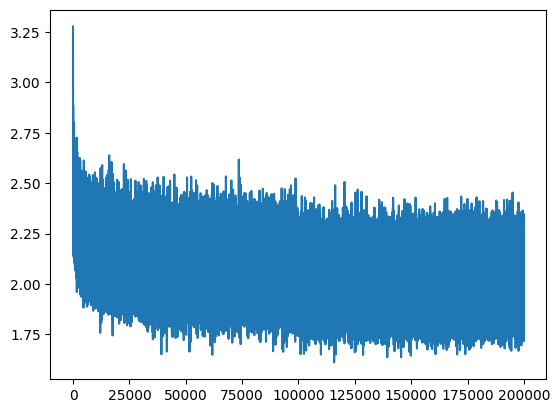

In [49]:
plt.plot(stepi, lossi)

In [50]:
@torch.no_grad()
def compute_loss(X, y):
    # forward
    emb = C[X]
    embcat = emb.view(len(X), -1)
    h = embcat @ W1 + b1
    bnraw = (h - running_mean) / torch.sqrt(running_var + epsilon)
    hbn = bnraw * bngain + bnbias
    hact = torch.tanh(hbn)
    logits = hact @ W2 + b2

    # compute loss
    loss = torch.nn.functional.cross_entropy(logits, y)

    return loss.item()

In [51]:
train_loss = compute_loss(X_train, y_train)
val_loss = compute_loss(X_val, y_val)
test_loss = compute_loss(X_test, y_test)
train_loss, val_loss, test_loss

(2.00002121925354, 2.0803074836730957, 2.094284772872925)

### Write own gradients (swoll doge :))

In [91]:
g = torch.Generator().manual_seed(2147483647)

emb_dim = 10
hidden_dim = 400
vocab_size = len(stoi)
block_size = 3

# emb matrix
C = torch.randn((vocab_size, emb_dim), dtype=torch.float32, generator=g)

# 1st linear layer
W1 = torch.randn((emb_dim * block_size, hidden_dim), dtype=torch.float32, generator=g) * 1/((emb_dim * block_size)**0.50)
b1 = torch.randn(hidden_dim, dtype=torch.float32, generator=g) * 0.10 # not really needed due to BN so expect the grads to be very small

# BatchNorm layer
bngain = torch.randn((1, hidden_dim), dtype=torch.float32, generator=g)
bnbias = torch.randn((1, hidden_dim), dtype=torch.float32, generator=g)

# 2nd linear layer
W2 = torch.randn((hidden_dim, vocab_size), dtype=torch.float32, generator=g) * 1/((hidden_dim)**0.50) * 0.10
b2 = torch.randn(vocab_size, dtype=torch.float32, generator=g) * 0.10

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

24297


In [93]:
batch_size = 128
n_iters = 200000
lr_scheduler = lambda i: 10**(-0.95) if i<100000 else 10**(-1.95)
epsilon = 1e-5
momentum = 0.005

In [94]:
# train loop
stepi, lossi = [], []

g = torch.Generator().manual_seed(2147483647)

running_mean, running_var = torch.zeros((1, hidden_dim)).float(), torch.ones((1, hidden_dim)).float()

for i in range(n_iters):
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,), generator=g)
    Xb, yb = X_train[ix], y_train[ix] # batch X,Y

    # embedding
    emb = C[Xb]
    embcat = emb.view(batch_size, -1)

    # linear layer 1
    h = embcat @ W1 + b1

    # batchnorm
    bnmean = torch.mean(h, dim=0, keepdim=True)
    bnvar = torch.var(h, dim=0, keepdim=True)
    bnvar_inv = (bnvar + epsilon) ** (-0.50)
    bnraw = (h - bnmean) * bnvar_inv
    hbn = bnraw * bngain + bnbias
    # update running stats
    with torch.no_grad():
        running_mean = momentum * bnmean + (1 - momentum) * running_mean
        running_var = momentum * bnvar + (1 - momentum) * running_var

    # tanh nonlinearity
    hact = torch.tanh(hbn)

    # linear layer 2
    logits = hact @ W2 + b2

    # compute loss
    loss = torch.nn.functional.cross_entropy(logits, yb)

    ## DEBUG: will remove all this till backward!!
    # set param grads to None, backward and update params
    # for p in parameters:
    #     p.grad = None

    # loss.backward()

    dC, dW1, db1, dbngain, dbnbias, dW2, db2 = None, None, None, None, None, None, None

    # write own grads :)
    with torch.no_grad():
        dlogits = torch.softmax(logits, dim=1)
        dlogits[range(batch_size), yb] -= 1.0
        dlogits *= (1/batch_size)
        
        dW2 = hact.T @ dlogits
        db2 = dlogits.sum(dim=0, keepdim=True).view(-1)
        dhact = dlogits @ W2.T

        dhbn = (1 - hact**2) * dhact

        dbngain = (bnraw * dhbn).sum(dim=0, keepdim=True)
        dbnbias = (dhbn).sum(dim=0, keepdim=True)

        dh = ((bngain * bnvar_inv) / batch_size) * (batch_size * dhbn -\
                                                         (batch_size / (batch_size - 1)) * bnraw * torch.sum(bnraw * dhbn, dim=0, keepdim=True) -\
                                                            torch.sum(dhbn, dim=0, keepdim=True))
        
        dW1 = embcat.T @ dh
        db1 = dh.sum(dim=0, keepdim=True).view(-1)
        dembcat = dh @ W1.T

        demb = dembcat.view(emb.shape)

        dC = torch.zeros_like(C)
        dC.index_add_(0, Xb.view(-1), demb.view(-1, emb_dim));

    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]


    with torch.no_grad():
        for p, grad in zip(parameters, grads):
            # print(p.shape, g.shape)
            p.data -= lr_scheduler(i) * grad.data

    if i % 10000 == 0:
        print(f"Step {i}/{n_iters} ---> {loss.item()}")

    stepi.append(i)
    lossi.append(loss.item())

Step 0/200000 ---> 3.277965784072876
Step 10000/200000 ---> 2.2029950618743896
Step 20000/200000 ---> 1.9918245077133179
Step 30000/200000 ---> 1.9321160316467285
Step 40000/200000 ---> 2.196713447570801
Step 50000/200000 ---> 2.333263397216797
Step 60000/200000 ---> 2.212798595428467
Step 70000/200000 ---> 2.121904134750366
Step 80000/200000 ---> 1.937780737876892
Step 90000/200000 ---> 1.9899792671203613
Step 100000/200000 ---> 1.9825620651245117
Step 110000/200000 ---> 2.068772792816162
Step 120000/200000 ---> 1.9552940130233765
Step 130000/200000 ---> 2.2605247497558594
Step 140000/200000 ---> 2.0887339115142822
Step 150000/200000 ---> 2.0170822143554688
Step 160000/200000 ---> 1.8849965333938599
Step 170000/200000 ---> 1.688709020614624
Step 180000/200000 ---> 2.0358822345733643
Step 190000/200000 ---> 1.950619101524353


In [95]:
train_loss = compute_loss(X_train, y_train)
val_loss = compute_loss(X_val, y_val)
test_loss = compute_loss(X_test, y_test)
train_loss, val_loss, test_loss

(2.00002121925354, 2.0803072452545166, 2.0942845344543457)